In [1]:
import os
from os.path import expanduser
home_dir = expanduser("~")
module_path = home_dir + '/code/modules/'
models_path = home_dir + '/models/'
import sys
sys.path.append(module_path)
fig_dir = 'figures/'
import time
import importlib
import random
import tensorflow as tf
import pandas as pd
from keras import regularizers
from keras.models import Sequential, Model, load_model
from keras.layers import Input, Dense, LeakyReLU, concatenate
from keras.callbacks import EarlyStopping
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy import stats
#import model_management
from scipy.special import comb
import datetime
import codecs, json
import corner
from itertools import combinations
%load_ext autoreload
%autoreload 1
%aimport data_processing
%aimport plotting
%aimport keras_objects
%aimport model_setup
from data_processing import *
from plotting import *
from keras_objects import *
from model_setup import *

np.random.seed(999)
random.seed(999)

Using TensorFlow backend.


In [ ]:
### Run on CPU only
os.environ["CUDA_VISIBLE_DEVICES"] = ""

## Set parameter string

In [ ]:
### Set name ending with parameters for figures to be saved
param_string = 'nLayers_%d_nNeurons_%d_actFun_%s_lossFunc_%s_nTrainSamples_%d_nEpochs_%d_batchSize_%d' % (
    nLayers, neuronsPerLayer, activationFunction, loss_function, train_size, nEpochs, batchSize)
print(param_string)

In [ ]:
print(np.mean(y_test_norm, 0))
print(np.std(y_test_norm, 0))
print(np.min(x_test_norm, 0))
print(np.max(x_test_norm, 0))

In [ ]:
### Get a feel for the data
for i in range(len(input_features)):
    print(input_features[i],': min: %.2e, max: %.2e.' % (np.min(x_train[:,i]), np.max(x_train[:,i])))
for i in range(len(output_features)):
    print(output_features[i],': min: %.2e, max: %.2e.' % (np.min(y_train[:,i]), np.max(y_train[:,i])))

In [ ]:
### Visualisation for when we have 2 input features
%matplotlib notebook
input_feat_1 = 0
input_feat_2 = 1
output_feat = 1

fig = plt.figure(1, figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x_train_norm[:500,input_feat_1], x_train_norm[:500,input_feat_2], 
           y_train_norm[:500,output_feat])
ax.set_xlabel('%s log($M_{H}/M_{S}$)' % (input_features[input_feat_1]))
ax.set_ylabel('%s log($M_{H}/M_{S}$)' % (input_features[input_feat_2]))
ax.set_zlabel('%s log($M_{G}/M_{S}$)' % (output_features[output_feat]))
plt.show()

## Load an existing model

In [ ]:
model = load_model()

In [ ]:
### Search for the model that you want
importlib.reload(model_management)
search_dict = {
    'training_method': 'backprop'
}
[model_dicts, description_dicts] = model_management.SearchModel(search_dict, get_hits=True)
print(description_dicts)
print('\n')
for key in model_dicts:
    print(key)
    print(model_dicts[key])
    print('\n')


In [ ]:
importlib.reload(model_management)
model, model_dict, description = model_management.LoadModel(search_dict, 1)

## Get the standard pictures

In [7]:
mode = 'test' # 'train', 'val, 'test'

In [8]:
norm_scores = model.evaluate(x=training_data_dict['input_test_dict'], y=training_data_dict['output_test_dict'],
                                               verbose=1)
tot_score = norm_scores[0]
predicted_points = predict_points(model, training_data_dict, data_type = mode)
title = 'Inputs: %s\n%.1e train points, test mse %.3e, %s data' % (', '.join(input_features), train_size, tot_score, mode)

100000/100000 [==============================] - 10s 101us/step


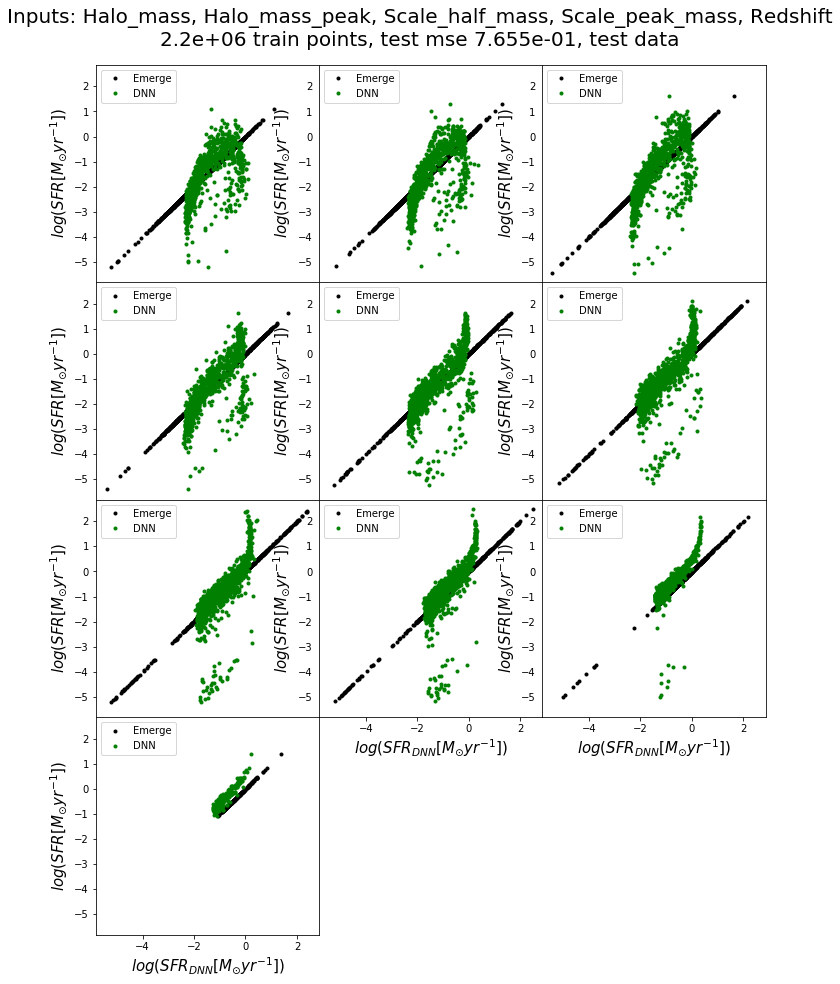

In [21]:
### Standard plots
fig1 = get_pred_vs_real_scatterplot(model, training_data_dict, unit_dict, data_keys, 'SFR', title=title, data_type=mode,
                                   predicted_points = predicted_points)
want to remove the ticks and labels between the plots...

In [ ]:
fig2 = get_real_vs_pred_boxplot(model, training_data_dict, unit_dict, data_keys, predicted_feat = 'Stellar_mass', 
                                binning_feat = 'Halo_mass', title=title, data_type=mode,
                                predicted_points = predicted_points)
fig3 = get_scatter_comparison_plots(model, training_data_dict, unit_dict, x_axis_feature = 'Halo_mass', 
                                    y_axis_feature = 'Stellar_mass', title=title, y_max = None, y_min = None,
                                    x_min = None, x_max = None, data_type=mode, predicted_points = predicted_points)
fig4 = get_real_vs_pred_boxplot(model, training_data_dict, unit_dict, data_keys, predicted_feat = 'SFR', 
                                binning_feat = 'Stellar_mass', title=title, data_type=mode,
                                predicted_points = predicted_points)
fig5 = get_scatter_comparison_plots(model, training_data_dict, unit_dict, x_axis_feature = 'Stellar_mass', 
                                    y_axis_feature = 'SFR', title=title, y_max = 5, y_min = None,
                                    x_min = None, x_max = None, data_type=mode, predicted_points = predicted_points)
plt.show

In [ ]:
fig6 = get_real_vs_pred_same_fig(model, training_data_dict, unit_dict, x_axis_feature='Halo_mass', 
                                 y_axis_feature = 'Stellar_mass', title=title, data_type=mode, marker_size=5,
                                 y_min=None, y_max=None, x_min=None, x_max=None)
fig7 = get_real_vs_pred_same_fig(model, training_data_dict, unit_dict, x_axis_feature='Stellar_mass', 
                                 y_axis_feature = 'SFR', title=title, data_type=mode, marker_size=2,
                                 y_min=None, y_max=None, x_min=None, x_max=None)
plt.show

In [ ]:
fig8, fig9 = get_sfr_stellar_mass_contour(model, training_data_dict, unit_dict, title=None, data_type='test',
                                 y_min=None, y_max=None, x_min=None, x_max=None, predicted_points=predicted_points)

In [ ]:
### Save the figures
date_string = datetime.datetime.now().strftime('%H-%M_%Y-%m-%d')
fig1.savefig(fig_dir + date_string + '_' + '_'.join(input_features) + '_to_' + '_'.join(output_features) +'_true_pred_sfr_scatter.png', bbox_inches = 'tight')
fig2.savefig(fig_dir + date_string + '_' + '_'.join(input_features) + '_to_' + '_'.join(output_features) + '_boxplot_stellar_mass.png', bbox_inches = 'tight')
fig3.savefig(fig_dir + date_string + '_' + '_'.join(input_features) + '_to_' + '_'.join(output_features) +'_scatter_comp_halo_vs_stellar_mass.png', bbox_inches = 'tight')
fig4.savefig(fig_dir + date_string + '_' + '_'.join(input_features) + '_to_' + '_'.join(output_features) +'_boxplot_sfr.png', bbox_inches = 'tight')
fig5.savefig(fig_dir + date_string + '_' + '_'.join(input_features) + '_to_' + '_'.join(output_features) +'_scatter_comp_stellar_mass_vs_sfr.png', bbox_inches = 'tight')

## Set model parameters

In [3]:
### General parameters
nr_steps = 5e2
nr_repetitions = 1
batch_size = 5e4
total_set_size = 2.4e6 # how many examples will be used for training+validation+testing
train_size = 2.2e6
val_size = .1e6
test_size = .1e6
norm = {'input': 'zero_mean_unit_std',
        'output': 'none'} # 'none',   'zero_mean_unit_std',   'zero_to_one'
input_features = ['Halo_mass', 'Halo_mass_peak', 'Scale_half_mass', 'Scale_peak_mass', 'Redshift']
output_features = ['Stellar_mass', 'SFR']
redshifts = [0,1,2,5,10,20,30,40,60,80]

outputs_to_weigh = ['Stellar_mass']
weigh_by_redshift = True

nr_epochs = nr_steps * batch_size / train_size

early_stop_patience = 5
early_stop_monitor = 'val_loss'
early_stop_min_delta = 1e-16

validation_data = 'val' #'val' is normally used, use 'train' to check overfitting potential

### Network parameters
nr_layers = 10
activation_function = 'tanh'
output_activation = {'SFR': None, 'Stellar_mass': None}
neurons_per_layer = 30
reg_strength = 0#1e-5


## Load data

In [4]:
# load the selected galaxyfile
galaxies, data_keys, unit_dict = load_galfiles(redshifts=redshifts, equal_numbers=False)
    
# prepare the training data
training_data_dict = divide_train_data(galaxies, data_keys, input_features, output_features, redshifts,
                                       int(total_set_size), int(train_size), int(val_size), int(test_size))
#galaxies = None
training_data_dict = normalise_data(training_data_dict, norm)

## Create model

In [5]:
model = standard_network(input_features, output_features, neurons_per_layer, nr_layers, activation_function, 
                         output_activation, reg_strength)
#model.summary()

## Train model

In [6]:
earlystop = EarlyStopping(monitor=early_stop_monitor, min_delta=early_stop_min_delta, patience=early_stop_patience, \
                          verbose=1, mode='auto')
#file_path = models_path + "model_checkpoint.hdf5"
#checkpoint = ModelCheckpoint(file_path, monitor='val_acc', save_best_only=True, mode='min', period=10)
#callbacks_list = [earlystop, checkpoint]
callbacks_list = [earlystop]

train_weights, val_weights = get_weights(training_data_dict, output_features, outputs_to_weigh, 
                                         weigh_by_redshift=weigh_by_redshift)

for i_rep in range(1, nr_repetitions+1):
    
    
    history = model.fit(x = training_data_dict['input_train_dict'], y = training_data_dict['output_train_dict'], 
                        validation_data = (training_data_dict['input_'+validation_data+'_dict'], 
                        training_data_dict['output_'+validation_data+'_dict'], val_weights), 
                        epochs=int(nr_epochs), batch_size=int(batch_size), callbacks=callbacks_list,
                        sample_weight=train_weights, verbose=1)
    #fig = get_scatter_comparison_plots(model, training_data_dict, unit_dict, x_axis_feature = 'Stellar_mass', 
    #                                y_axis_feature = 'SFR', title='rep %d/%d'%(i_rep,nr_repetitions), y_max = None, 
    #                                y_min = None,
    #                                x_min = None, x_max = None, data_type='val')
    #plt.show()

Train on 2200000 samples, validate on 100000 samples
Epoch 1/11
2200000/2200000 [==============================] - 6s 3us/step - loss: 3.3679e-05 - Stellar_mass_loss: 3.2363e-05 - SFR_loss: 1.3158e-06 - val_loss: 5.0310e-04 - val_Stellar_mass_loss: 4.7702e-04 - val_SFR_loss: 2.6089e-05
Epoch 2/11
2200000/2200000 [==============================] - 2s 1us/step - loss: 1.2498e-05 - Stellar_mass_loss: 1.1435e-05 - SFR_loss: 1.0621e-06 - val_loss: 1.3217e-04 - val_Stellar_mass_loss: 1.1559e-04 - val_SFR_loss: 1.6579e-05
Epoch 3/11
2200000/2200000 [==============================] - 2s 1us/step - loss: 3.6858e-06 - Stellar_mass_loss: 3.0645e-06 - SFR_loss: 6.2133e-07 - val_loss: 5.4815e-05 - val_Stellar_mass_loss: 4.2559e-05 - val_SFR_loss: 1.2256e-05
Epoch 4/11
2200000/2200000 [==============================] - 2s 1us/step - loss: 1.9346e-06 - Stellar_mass_loss: 1.3869e-06 - SFR_loss: 5.4767e-07 - val_loss: 3.8287e-05 - val_Stellar_mass_loss: 2.6471e-05 - val_SFR_loss: 1.1815e-05
Epoch 5/11


#### Plot loss history

In [ ]:
model.summary()

In [ ]:
# list all data in history
print(history.history.keys())

In [ ]:
# summarize history for loss
%matplotlib inline
fig = plt.figure(5, figsize=(8,8))
plt.plot(history.history['loss'], 'b')
plt.plot(history.history['val_loss'], 'r')
plt.yscale('log')
#plt.title(title)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

## Batch runs

#### Do a batch run to see which input parameters gives the best score

In [ ]:
total_set_size = 300000
train_size = 250000
val_size = 25000
test_size = 25000

core_input_features = ['Halo_mass', 'Halo_mass_peak', 'Scale_peak_mass']
tested_input_features = ['Concentration', 'Type', 'Scale_half_mass', 
                 'Scale_last_MajM', 'Environmental_density']
output_features = ['Stellar_mass', 'SFR']
nr_extra_params_list = [2]
nr_runs_per_comb = 3

nLayers = 10
activationFunction = 'tanh'
neuronsPerLayer = 30
loss_function = 'mse' # 'mse', 'weighted_mse_1' 'mae'
norm = 'zero_to_one' # 'none',   'zero_mean_unit',   'zero_to_one'

nr_steps = 1e4
batch_size = 4e4

verb = 0 # prints progress to stdout

nr_epochs = nr_steps * batch_size / train_size
parameter_dictionary = {
    'fixed_input_features': core_input_features,
    'tested_input_features': tested_input_features,
    'output_features': output_features,
    'nr_extra_parameter_combinations': nr_extra_params_list,
    'nr_steps': [nr_steps],
    'batch_size': [batch_size],
    'nr_epochs': [nr_epochs],
    'nr_training_samples': [train_size],
    'nr_validation_samples': [val_size],
    'nr_test_samples': [test_size],
    'data_normalization': norm,
    'activation_function': activationFunction,
    'neurons_per_layer': [neuronsPerLayer],
    'nr_hidden_layers': [nLayers],
    'output_activation_function': 'none',
    'description': 'Each parameter setting is represented by one list containing three objects. The first one is ' + \
    'the input parameters. The second one is the mse test scores obtained for the different runs evaluated on the ' +\
    'normed units and the original units of the data set (original only if norm is \'none\'). The third one is the ' +\
    'loss histories for the different runs [training_loss, validation_loss] evaluated on the normalised data.'
}
results_list = [parameter_dictionary]
nr_combs_total = 0
for nr_extra_params in nr_extra_params_list:
    nr_combs_total += comb(len(tested_input_features), nr_extra_params)
comb_counter = 0 # to keep track of how many combinations I've gone through

with open('model_comparisons/progress.txt', 'w+') as f:
    
    date_string_proper = datetime.datetime.now().strftime("%H:%M, %Y-%m-%d")
    f.write('Benchmark done on input parameters at ' + date_string_proper + '\n\n')
    f.flush()
    
    # load the selected galaxyfile
    galaxies, data_keys, unit_dict = load_galfile()
    
    for i_nr_extra_params, nr_extra_params in enumerate(nr_extra_params_list):
        
        extra_param_combs = list(combinations(tested_input_features, nr_extra_params))
        
        date_string_proper = datetime.datetime.now().strftime("%H:%M, %Y-%m-%d")
        f.write(date_string_proper + '    Testing %d extra parameters. %d/%d extra parameter count tested. \n\n' %
                (nr_extra_params, i_nr_extra_params+1, len(nr_extra_params_list)))
        f.flush()
    
        for i_comb, param_comb in enumerate(extra_param_combs):
            input_features = core_input_features.copy()
            input_features.extend(param_comb)
            
            # prepare the training data
            training_data_dict = divide_train_data(galaxies, data_keys, input_features, output_features, 
                                                   total_set_size, train_size, val_size, test_size)
            training_data_dict = normalise_data(training_data_dict, norm)
            
            date_string_proper = datetime.datetime.now().strftime("%H:%M, %Y-%m-%d")
            comb_counter += 1
            f.write(date_string_proper + '        Testing combination %d/%d. \n\n' % (comb_counter, nr_combs_total))
            f.flush()
            
            original_scores = []
            if not norm == 'none':
                normed_scores = []
            histories = []

            for i_run in range(nr_runs_per_comb):

                # create model
                model = Sequential()
                model.add(Dense(neuronsPerLayer, input_dim = len(input_features), activation = activationFunction))

                for i in range(0, nLayers-1): # -1 because one layer is added automatically with the input layer
                    model.add(Dense(neuronsPerLayer, activation = activationFunction))

                model.add(Dense(len(output_features)))

                # Compile model
                earlystop = EarlyStopping(monitor='val_loss', min_delta=1e-7, patience=100, \
                          verbose=1, mode='auto')
                callbacks_list = [earlystop]
                model.compile(loss=loss_func_dict[loss_function], optimizer='adam')

                # Fit the model
                if norm == 'none':
                    history = model.fit(training_data_dict['x_train'], training_data_dict['y_train'], 
                                        validation_data=(training_data_dict['x_val'], training_data_dict['y_val']), 
                                        epochs=int(nr_epochs), batch_size=int(batch_size), callbacks=callbacks_list, 
                                        verbose=verb)
                    orig_score = model.evaluate(x=training_data_dict['x_test'], y=training_data_dict['y_test'],
                                               verbose=verb)
                    original_scores.append(orig_score)
                    
                else:
                    history = model.fit(training_data_dict['x_train_norm'] , training_data_dict['y_train_norm'], 
                                        validation_data=(training_data_dict['x_val_norm'], 
                                        training_data_dict['y_val_norm']), 
                                        epochs=int(nr_epochs), batch_size=int(batch_size), callbacks=callbacks_list, 
                                        verbose=verb)
                    norm_score = model.evaluate(x=training_data_dict['x_test_norm'], y=training_data_dict['y_test_norm'],
                                               verbose=verb)
                    normed_scores.append(norm_score)
                    orig_score = get_test_score(model, training_data_dict, norm)
                    original_scores.append(orig_score)
                    
                histories.append([history.history['loss'], history.history['val_loss']])
                
            if norm == 'none':
                scores = original_scores
            else:
                scores = [normed_scores, original_scores]
                
            results_list.append([input_features, scores, histories])
            
    date_string_proper = datetime.datetime.now().strftime("%H:%M, %Y-%m-%d")
    f.write('Benchmark completed at ' + date_string_proper + '\n')
    f.flush()
        

#### Save the result

In [ ]:
### Save the result
date_string = datetime.datetime.now().strftime('%Y-%m-%d--%H-%M-%S')
custom_string = '5_total_inputs'
with open('model_comparisons/' + custom_string + '.json', 'w+') as f:
    json.dump(results_list, f)
f.close()

In [ ]:

#print(train_loss)
print('Lowest train/val/test loss: %.2f, %.2f, %.2f' % (np.amin(train_loss), np.amin(val_loss), np.amin(test_loss)))

#### Load a batch run result

In [ ]:
### Load a result
loaded_list_string = '5_total_inputs'
with open('model_comparisons/' + loaded_list_string + '.json', 'r') as f:
    results_list = json.load(f)
f.close()

print(results_list[0])

#### Plot the results

In [ ]:
print(len(results_list[1][1]))
print(results_list[1][1])

In [ ]:
### Plot the loss histories to make sure that the best performance was reached

for comb_nr, lst in enumerate(results_list[1:]):

    title = lst[0]
    train_loss = lst[2][0][0]
    val_loss = lst[2][0][1]
    test_loss = lst[1][0]

    #print('Lowest train/val/test loss: %.2e, %.2e, %.2e' % (np.amin(train_loss), np.amin(val_loss), np.amin(test_loss)))

    # summarize history for loss
    fig = plt.figure(5, figsize=(8,8))
    for i_run in range(len(test_loss)):
        train_loss = lst[2][i_run][0]
        val_loss = lst[2][i_run][1]
        plt.plot(train_loss, 'b')
        plt.plot(val_loss, 'r')
    plt.yscale('log')
    plt.title(title)
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper right')
    plt.show()


In [ ]:
print(results_list[1][0])

In [ ]:
### Get the X best performing input parameters
get_normed_scores = 1
top_nr_of_parameter_combs = 10
column_widths = [0.2, 0.05]
test_results = []
val_results = []
for comb_nr, lst in enumerate(results_list[1:]):
    if get_normed_scores:
        best_test = np.amin(lst[1][0])
    else:
        best_test = np.amin(lst[1][1])
        
#    val_losses = []
#    for i_run in range(len(lst[1])):
#        val_losses.append(lst[2][i_run][1])
        
    test_results.append(best_test)
#    val_results.append(np.amin(val_losses))
    
best_test_indices = np.argsort(test_results)
#best_val_indices = np.argsort(val_results)

fig1362 = plt.figure(figsize=(16,8))

ax = plt.subplot(1,1,1)

collabel=('Input parameters', 'best test mse\n(normalised units)')
table_vals = []
for i in range(top_nr_of_parameter_combs):
    
    inputs = ', '.join(results_list[best_test_indices[i]+1][0][:3])
    inputs = inputs + '\n+\n' + ', '.join(results_list[best_test_indices[i]+1][0][3:])
    
    table_vals.append([inputs, '%.3e' % 
                      (np.amin(results_list[best_test_indices[i]+1][1]))])

the_table = ax.table(cellText=table_vals,colLabels=collabel,colWidths=column_widths,loc='center')
the_table.set_fontsize(15)
the_table.scale(3, 4)
ax.axis('tight')
ax.axis('off')
plt.title('# weight updates: %.1e, batch size: %.1e,\nnorm: %s, output norm: False, 10 layers, 30 neurons per layer' % 
          (results_list[0]['nr_steps'][0], results_list[0]['batch_size'][0], results_list[0]['data_normalization']) +
           '\nFixed input parameters: %s' % (', '.join(results_list[0]['fixed_input_features'])), 
          fontsize=20)
ttl = ax.title
ttl.set_position([0.5, 1.15])

plt.show()

In [ ]:
fig1362.savefig(fig_dir + '5_total_inputs' + '_param_comb_scores_test.png', bbox_inches = 'tight')

In [ ]:
### Plot best validation scores
fig2 = plt.figure(figsize=(16,8))


ax = plt.subplot(1,1,1)

collabel=('Input parameters', 'best val mse\n(scaled units)')
table_vals = []
for i in range(top_nr_of_parameter_combs):
    
    inputs = ', '.join(results_list[best_val_indices[i]+1][0])
    
    table_vals.append([inputs, '%.3f' % 
                      (val_results[best_val_indices[i]])])

the_table = ax.table(cellText=table_vals,colLabels=collabel,colWidths=column_widths,loc='center')
the_table.set_fontsize(15)
the_table.scale(3, 3)

plt.subplots_adjust(left=None, bottom=None, right=None, top=None,
                wspace=0.2, hspace=0.5)

ax.axis('tight')
ax.axis('off')
plt.title('# weight updates: %.1e, batch size: %.1e,\nnorm: %s, relu on output: False, 10 layers, 10 neurons per layer' % 
          (results_list[0]['nr_steps'][0], results_list[0]['batch_size'][0], results_list[0]['data_normalization'], 
          ), fontsize=20)
ttl = ax.title
ttl.set_position([0.5, 1])

#plt.tight_layout(h_pad=30)

plt.show()

In [ ]:
fig2.savefig(fig_dir + '2018-05-12--13-36-02_param_comb_scores_val.png', bbox_inches = 'tight')

In [ ]:
### Find out how a parameter affects the result
collabel = ('Input parameter', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10')
first_col_width = .1
last_col_width = .02
column_widths = [first_col_width]
for i in range(10):
    column_widths.append(last_col_width)
tab_rows = []
row_colours = []

for param in results_list[0]['tested_input_features']:
    
    tab_row = [param]
    row_colour = ['w']

    for i, ind in enumerate(best_test_indices[:10]):
        inputs = results_list[ind+1][0]
        if param in inputs:
            tab_row.append('Yes')
            row_colour.append('g')
        else:
            tab_row.append('No')
            row_colour.append('r')

    tab_rows.append(tab_row)
    row_colours.append(row_colour)
        
fig8845 = plt.figure(figsize=(16,8))

ax = plt.subplot(111)

the_table = ax.table(cellText=tab_rows,colLabels=collabel,colWidths=column_widths,
                     cellColours=row_colours,loc='center')
the_table.set_fontsize(15)
the_table.scale(3, 3)

plt.subplots_adjust(left=None, bottom=None, right=None, top=None,
                wspace=0.2, hspace=0.5)
plt.title('# weight updates: %.1e, batch size: %.1e,\nnorm: %s, output norm: False, 10 layers, 30 neurons per layer'
          % (results_list[0]['nr_steps'][0], results_list[0]['batch_size'][0], results_list[0]['data_normalization'])+
           '\nFixed input parameters: %s\nOrdering based on test scores (normalised units)' % 
          (', '.join(results_list[0]['fixed_input_features'])), fontsize=20)
#plt.title('Ordering based on validation scores', fontsize=20)
ttl = ax.title
ttl.set_position([0.5, 0.8])

#ax.axis('tight')
ax.axis('off')

plt.show()
    

In [ ]:
fig8845.savefig(fig_dir + '5_total_inputs' + '_param_importance_test.png', bbox_inches = 'tight')

## Hyperparameter search

In [ ]:
nr_folds = 1
#total_set_size = int(1e4 + 1/(nr_folds-1)*1e4)
total_set_size = 3.5e4
train_size = 1e4
val_size = 2.5e4
test_size = 0

input_features = ['Halo_mass', 'Halo_mass_peak', 'Scale_peak_mass', 'Scale_half_mass', 'Scale_last_MajM']
output_features = ['Stellar_mass', 'SFR']
outputs_to_weigh = ['Stellar_mass']

nr_layers = [3, 8, 20]
neurons_per_layer = [3, 10, 30]
activation_functions = ['leaky_relu', 'tanh']

loss_function = 'mse' # 'mse', 'weighted_mse_1' 'mae'
input_norms = ['zero_mean_unit_std', 'zero_to_one']
output_activation = {'SFR': None, 'Stellar_mass': None}
reg_strengths = [0, 1e-10, 1e-2]

nr_steps = [5e3]
batch_sizes = np.array([1e3, 5e3, 1e4])
nr_epochs = nr_steps * batch_sizes / train_size
early_stop_patience = 200
early_stop_min_delta = 1e-20

verb = 0 # prints progress to stdout

parameter_dictionary = {
    'input_features': input_features,
    'output_features': output_features,
    'outputs_to_weigh': outputs_to_weigh,
    'loss_function': loss_function,
    'nr_steps': nr_steps,
    'batch_sizes': batch_sizes,
    'nr_epochs': nr_epochs,
    'total_set_size': [total_set_size],
    'reg_strengths': reg_strengths,
    'nr_folds': nr_folds,
    'input_norms': input_norms,
    'activation_functions': activation_functions,
    'neurons_per_layer': neurons_per_layer,
    'nr_hidden_layers': nr_layers,
    'output_activation_function': 'none',
    'description': 'Each parameter setting is represented by one list containing four objects. The first one is ' + \
    'the parameters of the model. The second one is a list with 1: the mean best val score obtained based on the '+\
    'k folds, 2: the std for these scoresl and 3: the best validation score from all folds and histories.' +\
    'The third one is the training' +\
    'loss histories for the different folds and the fourth one is the validation loss histories on the different folds.'
}
results_list = [parameter_dictionary]
tot_nr_runs = len(nr_layers) * len(neurons_per_layer) * len(activation_functions) * len(input_norms) * \
                len(batch_sizes) * len(reg_strengths) * nr_folds
run_counter = 0 # to keep track of how many combinations I've gone through

earlystop = EarlyStopping(monitor='val_loss', min_delta=1e-7, patience=100, \
                          verbose=1, mode='auto')
callbacks_list = [earlystop]

with open('hyperparameter_searches/progress.txt', 'w+') as f:
    
    date_string_proper = datetime.datetime.now().strftime("%H:%M, %Y-%m-%d")
    f.write('Benchmark done on input parameters at ' + date_string_proper + '\n\n')
    f.flush()
    
    # load the selected galaxyfile, be sure that the autoloaded galaxyfile is the one that you want to use!!
    galaxies, data_keys, unit_dict = load_galfile()
    
    for i_act_fun, act_fun in enumerate(activation_functions):
        for i_reg_strength, reg_strength in enumerate(reg_strengths):
            for i_inp_norm, inp_norm in enumerate(input_norms):
                norm = {'input': inp_norm,
                        'output': 'none'}
                for i_neur_per_lay, neur_per_lay in enumerate(neurons_per_layer):
                    for i_nr_lay, nr_lay in enumerate(nr_layers):
                        for i_batch_size, batch_size in enumerate(batch_sizes):
                        
                        
                            train_histories = []
                            val_histories = []
                            scores = []
                            
                            for fold in range(nr_folds):
                                
                                date_string_proper = datetime.datetime.now().strftime("%H:%M, %Y-%m-%d")
                                run_counter += 1
                                f.write(date_string_proper + '        Run nr %d/%d. \n\n' % (run_counter, tot_nr_runs))
                                f.flush()

                                # prepare the training data
                                training_data_dict = divide_train_data(galaxies, data_keys, input_features, 
                                                                       output_features, int(total_set_size), 
                                                                       train_size=int(train_size), 
                                                                       val_size=int(val_size), test_size=int(test_size))
                                                   #  divide_train_data(galaxies, data_keys, input_features, 
                                                   #                    output_features, total_set_size, k_fold_cv=True, 
                                                   #                    tot_cv_folds=nr_folds, cv_fold_nr=fold)
                                training_data_dict = normalise_data(training_data_dict, norm)
                                
                                # set data point weights
                                train_weights, val_weights = get_weights(training_data_dict, output_features, 
                                                                         outputs_to_weigh)
                                
                                # Create model
                                main_input = Input(shape=(len(input_features),), name = 'main_input')
                                
                                if act_fun == 'leaky_relu':
                                    x1 = Dense(neur_per_lay, kernel_regularizer=regularizers.l2(reg_strength))(main_input)
                                    x2 = Dense(neur_per_lay, kernel_regularizer=regularizers.l2(reg_strength))(main_input)
                                    x1 = LeakyReLU(alpha = 0.1)(x1)
                                    x2 = LeakyReLU(alpha = 0.1)(x2)
                                else:
                                    x1 = Dense(neur_per_lay, kernel_regularizer=regularizers.l2(reg_strength), 
                                              activation=act_fun)(main_input)
                                    x2 = Dense(neur_per_lay, kernel_regularizer=regularizers.l2(reg_strength), 
                                              activation=act_fun)(main_input)
                                    
                                for i in range(0, nr_lay-1): # -1 because one is added automatically
                                    if act_fun == 'leaky_relu':
                                        x1 = Dense(neur_per_lay, kernel_regularizer=regularizers.l2(reg_strength))(x1)
                                        x2 = Dense(neur_per_lay, kernel_regularizer=regularizers.l2(reg_strength))(x2)
                                        x1 = LeakyReLU(alpha = 0.1)(x1)
                                        x2 = LeakyReLU(alpha = 0.1)(x2)
                                        
                                    else:
                                        x1 = Dense(neur_per_lay, kernel_regularizer=regularizers.l2(reg_strength), 
                                                  activation=act_fun)(x1)
                                        x2 = Dense(neur_per_lay, kernel_regularizer=regularizers.l2(reg_strength), 
                                                  activation=act_fun)(x2)

                                output_layers = []
                                output_layers.append(Dense(1, kernel_regularizer=regularizers.l2(reg_strength), 
                                                           name = 'Stellar_mass',
                                                           activation = output_activation['Stellar_mass'])(x1))
                                output_layers.append(Dense(1, kernel_regularizer=regularizers.l2(reg_strength), 
                                                           name = 'SFR',
                                                           activation = output_activation['SFR'])(x2))

                                model = Model(main_input, output_layers)
                                model.compile(optimizer = 'adam', loss = loss_function)

                                # Fit the model
                                history = model.fit(x = training_data_dict['input_train_dict'], 
                                                    y = training_data_dict['output_train_dict'], 
                                                    validation_data = (training_data_dict['input_val_dict'], 
                                                    training_data_dict['output_val_dict'], val_weights), 
                                                    epochs=int(nr_epochs[i_batch_size]), batch_size=int(batch_size), 
                                                    callbacks=callbacks_list, sample_weight=train_weights, verbose=verb)

                                train_histories.append(history.history['loss'])
                                val_histories.append(history.history['val_loss'])
                                scores.append(np.amin(history.history['val_loss']))
                                
                            best_score = np.amin(scores)
                            mean_score = np.mean(scores)
                            score_std = np.std(scores)
                            total_score = [mean_score, score_std, best_score]
                            parameters = {'inp_norm': inp_norm, 'nr_lay': nr_lay, 'neur_per_lay': neur_per_lay, 
                                         'act_fun': act_fun, 'batch_size': batch_size, 'reg_strength': reg_strength}
                            results_list.append([parameters, total_score, train_histories, val_histories])
            
    date_string_proper = datetime.datetime.now().strftime("%H:%M, %Y-%m-%d")
    f.write('Benchmark completed at ' + date_string_proper + '\n')
    f.flush()
        

In [ ]:
print(results_list[1][2])

In [ ]:
### Plot the loss histories to make sure that the best performance was reached
for comb_nr, lst in enumerate(results_list[1:]):

    title = str(lst[0]) + '\n mean final validation score: {:.2e}$\pm${:.2e}'.format(lst[1][0], lst[1][1])
    train_losses = lst[2]
    val_losses = lst[3]

    #print('Lowest train/val/test loss: %.2e, %.2e, %.2e' % (np.amin(train_loss), np.amin(val_loss), np.amin(test_loss)))

    # summarize history for loss
    fig = plt.figure(5, figsize=(8,8))
    for train_loss, val_loss in zip(train_losses, val_losses):
        plt.plot(train_loss, 'b')
        plt.plot(val_loss, 'r')
    plt.yscale('log')
    plt.title(title)
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper right')
    plt.show()


In [ ]:
print(list(history.history.keys()))

In [ ]:
### Save the result
date_string = datetime.datetime.now().strftime('%Y-%m-%d--%H-%M-%S')
custom_string = '5_total_inputs'
with open('hyperparameter_searches/' + date_string + '.json', 'w+') as f:
    json.dump(results_list, f)
f.close()

## Evaluate the model

In [ ]:
# On preprocessed data
test_loss, test_mse = model.evaluate(x_test_norm, y_test_norm, verbose=0)
print('MSE for the processed data: %.4f' % (test_mse))

In [ ]:
### Predict real value of points
if norm == 'zero_mean_unit_std':
    predicted_norm_points = model.predict(training_data_dict['x_test_norm'])
    predicted_points = predicted_norm_points * training_data_dict['y_data_stds'] + training_data_dict['y_data_means']
    
if norm == 'zero_to_one':
    predicted_norm_points = model.predict(training_data_dict['x_test_norm'])
    predicted_points = predicted_norm_points * (training_data_dict['y_data_max'] - training_data_dict['y_data_min']) + \
                        training_data_dict['y_data_min']

In [ ]:
### Get mse for the real predictions
n_points = np.shape(predicted_points)[0]
x_minus_y = predicted_points - y_test

feature_scores = np.sum(np.power(x_minus_y, 2), 0) / n_points
total_score = np.sum(feature_scores) / 2

print('MSE for the unprocessed data: %.4f' % (total_score))

## Save a model

In [ ]:
### Save the model if it is useful
importlib.reload(model_management)
model_dictionary = {
    'training_method': 'backprop',
    'input_features': input_features,
    'output_features': output_features,
    'number_of_epochs': nEpochs,
    'batch_size': batchSize,
    'number_of_layers': nLayers,
    'neurons_per_layer': neuronsPerLayer,
    'activation_function': activationFunction,
    'train_set_size': train_size,
    'loss_function': loss_function,
    'test_loss': test_loss,
    'test_mse': test_mse,
    'preprocess_data': preprocess_data
}
description = 'First network trained on preprocessed data.'
model_management.SaveModel(model, model_dictionary, description)

In [ ]:
%matplotlib notebook
#x1 = np.linspace(np.min(x_test[:,0]), np.max(x_test[:,0]), 30)
#x2 = np.linspace(np.min(x_test[:,1]), np.max(x_test[:,1]), 30)
#X1, X2 = np.meshgrid(x1, x2)
#Z = np.zeros(X1.shape)
#for i in range(30):
#    for j in range(30):
#        Z[i, j] = model.predict(np.array([X1[i,j], X2[i,j]])) TODO varför funkar inte det här??
        
#fig = plt.figure(4)
#ax = plt.axes(projection='3d')
#ax.contour3D(X, Y, Z, 50, cmap='binary')
#ax.set_xlabel('x')
#ax.set_ylabel('y')
#ax.set_zlabel('z')
        
### Old visualisation way
### Visualisation of prediction strength for when we have 2 input features
if plot_threeD and len(input_features) == 2:
    predictedY = model.predict(x_test_norm)
    predictedY = predictedY * y_data_stds + y_data_means
    fig = plt.figure(2, figsize=(8,8))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(x_test[:,0], x_test[:,1], 
               y_test[:,0], s=3)
    ax.scatter(x_test[:,0], x_test[:,1], 
               predictedY, s=3)
    ax.set_xlabel('%s log($M_{H}/M_{S}$)' % (input_features[0]))
    ax.set_ylabel('%s log($M_{H}/M_{S}$)' % (input_features[1]))
    ax.set_zlabel('%s log($M_{G}/M_{S}$)' % (output_features[0]))

### Check to see how the MSE is calculated 

In [ ]:
predicted_points = model.predict(x_test)
print(np.shape(predicted_points))
n_points = np.shape(predicted_points)[0]
x_minus_y = predicted_points - y_test

feature_scores = np.sum(np.power(x_minus_y, 2), 0) / n_points
total_score = np.sum(feature_scores) / 2

print(total_score)

keras_scores = model.evaluate(x_test, y_test, verbose=0)
print(keras_scores)

In [ ]:
# summarize history for loss
%matplotlib inline
fig = plt.figure(5, figsize=(8,8))
plt.plot(history.history['loss'], 'b')
plt.plot(history.history['val_loss'], 'r')
plt.yscale('log')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

## Old code

In [ ]:
# Create model TESTING
inputs = []

main_input = Input(shape=(len(input_features),), name = 'main_input')
halo_mass_input = Input(shape=(1,), name = 'Halo_mass')
sfr_input = Input(shape=(1,), name = 'SFR')
stellar_mass_input = Input(shape=(1,), name = 'Stellar_mass')
inputs.append(main_input)
inputs.append(halo_mass_input)
#inputs.append(sfr_input)
#inputs.append(stellar_mass_input)
#for i_feat, feat in enumerate(weighted_output_features):
#    inputs.append(Input(shape=(1,), name = feat))
    
for i in range(0, nLayers-1): # -1 because one layer is added automatically with the input layer
    if i == 0:
        #x = concatenate([halo_mass_input, others_input])
        #x = Dense(neuronsPerLayer, activation = activationFunction)(main_input)
        x = Dense(neuronsPerLayer, kernel_regularizer=regularizers.l2(reg_strength))(main_input)
        x = LeakyReLU(alpha = 0.1)(x)
    else:
        #x = Dense(neuronsPerLayer, activation = activationFunction)(x)
        x = Dense(neuronsPerLayer, kernel_regularizer=regularizers.l2(reg_strength))(x)
        x = LeakyReLU(alpha = 0.1)(x)
        
outputs = []

sfr_output = Dense(1, kernel_regularizer=regularizers.l2(reg_strength))(x)
sfr_weigh_loss = Nonweighted_loss_layer()([sfr_input, sfr_output])

stellar_mass_output = Dense(1, kernel_regularizer=regularizers.l2(reg_strength))(x)
stellar_mass_weigh_loss = Weighted_loss_layer()([halo_mass_input, stellar_mass_input, 
                                                                    stellar_mass_output])

outputs.append(sfr_weigh_loss)
outputs.append(stellar_mass_weigh_loss)

#out = Weighted_loss_layer()([halo_mass_input, ])

model = Model(inputs, outputs)

In [ ]:



model_core.compile(optimizer = 'adam', loss = tunnel_loss)

earlystop = EarlyStopping(monitor=early_stop_monitor, min_delta=early_stop_min_delta, patience=early_stop_patience, \
                          verbose=1, mode='auto')
callbacks_list = [earlystop]

history = model_core.fit(x = training_data_dict['input_train_dict'], y = training_data_dict['output_train_dict'], 
                    validation_data = (training_data_dict['input_'+validation_data+'_dict'], 
                    training_data_dict['output_'+validation_data+'_dict']), 
                    epochs=int(nr_epochs), batch_size=int(batch_size), callbacks=callbacks_list)

In [ ]:
weights = model.layers[5].get_weights()
print(weights)